# Determining parameters


The Fourier transform of the convolutional line profile arising from planar faults, dislocations, and size effects can be evaluated as 

$$
A_{hkl}(L) = A_S(L)A_D(L)A_F(L),
$$

where the variable $L$ is relted to $\kappa$ through the Fourier-transform and $\kappa$ is defined as

$$
\kappa = \frac{2\sin \theta}{\lambda}.
$$

The profile can then be evaluated as 

$$
I(\kappa)_{hkl} = \int_{-\infty}^\infty e^{2\pi i \kappa L}A_{hkl}(L)dL.
$$

The observed spectrum is a linear combination of these. We therefore have to sum over the Miller-indices as

$$
I(\kappa) = \sum_{h,k,l}I_{hkl}^{max}I(\kappa-g_{hkl})_{hkl}.
$$

Generally, we assume that the lattice constant $a$, the Burgers vector $b$, and $C_{h00}$ are known for the sample. Then, the parameters to be determined are

- $\rho$
- $m$
- $\sigma$
- $q$
- $R^*$
- $\beta$ or $\alpha$, the planar fault probability

In addition, the peak locations and peak amplitudes are also to be determined.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
import matplotlib

In [3]:
%load_ext autoreload
%autoreload 2
%aimport  diffaultpy

In [4]:
from diffaultpy.peak_shapes import Peak, generate_multiple_peaks


In [5]:
N = 1024 * 8 


Here we initialize a Peak object

with the following properties.

$$a =0.36, b =0.255, C_{h00}=0.1. $$


The computational domain will correspond to $\kappa \in [0, \kappa_{max}]$ with $\kappa_{max}=14$. 

In [6]:
lattice_constant = 0.36



Let us also fix the following parameters

$$
\rho = 0.01, m = 10, R^* = 60, \sigma = 0.001,  q=2, B = 0.05
$$


In [7]:
rho_true = 0.01
m_true = 20
Rstar_true = 5
sigma_true = 0.1
q_true = 3
B_true = 0.05

Assuming an FCC lattice, we'll simulate a spectrum corresponding to the first 5 peaks.

In [8]:
np.random.seed(4)
intensities = np.random.rand(5,1)
offsets = (np.random.rand(5,1) -0.5) * 1e-3


In [9]:
h, k, l = 2, 0, 0
kappa_max = 14
N_fourier = 8192
lattice_constant = 0.36
burgers_vector = 0.255
Ch00 = 0.36
single_peak = Peak(kappa_max,
                    N_fourier, 
                    Ch00, 
                    burgers_vector,
                      lattice_constant, 
                      stacking_or_twin_fault='stacking',
                        approximation_wilkens='polynomial')


In [11]:
true_spectrum = generate_multiple_peaks(single_peak,
                                        m_true,
                                        sigma_true,
                                        rho_true,
                                        Rstar_true,
                                        q_true,
                                        peak_intensities=intensities,
                                        planar_fault_probability=B_true,
                                       offset=offsets)

Text(0, 0.5, 'Intensity')

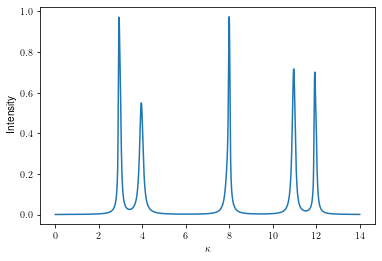

In [13]:
plt.plot(single_peak.positive_diffraction_vectors, true_spectrum)
plt.xlabel('$\kappa$')
plt.ylabel('Intensity')

Let us set up a loss function for the optimization. Combine all variables into a single vector first.

In [14]:
def unpack_x(x):
    m, sigma, B, rho, Rstar, q = x[:6]
    intensity = x[6:11].reshape(-1,1)
    offset = x[11:].reshape(-1,1)
    return m, sigma, B, rho, Rstar, q, intensity, offset

In [20]:
def loss(x):
    m, sigma, B, rho, Rstar, q = x[:6]
    intensity = x[6:11].reshape(-1,1)
    offset = x[11:].reshape(-1,1)
    spectrum = generate_multiple_peaks(single_peak,
                                        m,
                                        sigma,
                                       rho,
                                        Rstar,
                                        q,
                                        peak_intensities=intensity,
                                       planar_fault_probability=B,
                                       offset=offset)
    return np.ravel(true_spectrum - spectrum)

In [21]:
true_x = np.concatenate(([m_true, sigma_true, B_true, rho_true, Rstar_true, q_true], *intensities, *offsets))

In [22]:
from scipy.optimize import least_squares

In [23]:
np.random.seed(3)
x_0 = true_x + (np.random.rand(16)*0.05)

In [24]:
res = least_squares(loss, x_0)

/Users/balintkaszas/Diffault/diffaultpy/math_backend.py:127: RuntimeWarning: invalid value encountered in log
  return np.log(x)
/Users/balintkaszas/Diffault/diffaultpy/math_backend.py:104: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
/Users/balintkaszas/Diffault/diffaultpy/math_backend.py:139: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(x)


In [25]:
m, sigma, B, rho, Rstar, q, intensity, offset = unpack_x(res.x)

In [27]:
predicted_spectrum = generate_multiple_peaks(single_peak,
                                        m,
                                        sigma,
                                        rho,
                                        Rstar,
                                        q,
                                        peak_intensities=intensity,
                                             planar_fault_probability=B,
                                       offset = offset)

Text(0, 0.5, 'Intensity')

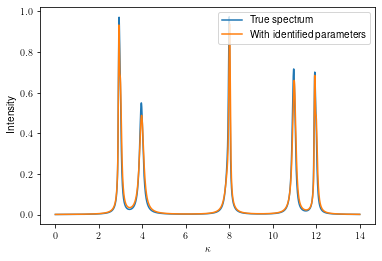

In [28]:
plt.plot(single_peak.positive_diffraction_vectors, true_spectrum, label = 'True spectrum')
plt.plot(single_peak.positive_diffraction_vectors, predicted_spectrum, label = 'With identified parameters')
plt.legend()
plt.xlabel('$\\kappa$')
plt.ylabel('Intensity')


Text(0, 0.5, 'Error')

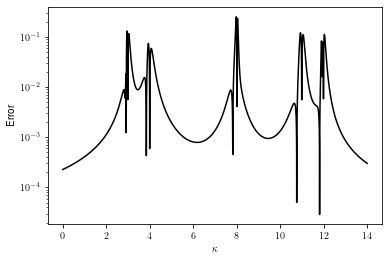

In [29]:
plt.semilogy(single_peak.positive_diffraction_vectors, np.abs(true_spectrum-predicted_spectrum), c='black')
plt.xlabel('$\\kappa$')
plt.ylabel('Error')


## Generate multiple spectra at once

In [30]:
domains = {'B': [0, 0.05],
           'm': [5., 100.],
           'sigma': [0.1, 1.],
           'rho': [0.0005, 0.05],
           'Rstar' : [2., 100.],
           'q' : [1.5, 2.3],
           'offset' : [-0.05, 0.05],
           'intensity' : [0, 1]
          }

def generate_spectra_in_domain(num_spectra, num_peaks, domains, seed = 0):
    torch.manual_seed(seed)
    params = {}
    
    params['m'] = (domains['m'][1] - domains['m'][0]) * torch.rand(1, num_spectra) + domains['m'][0]
    params['sigma'] = (domains['sigma'][1] - domains['sigma'][0]) * torch.rand(1, num_spectra) + domains['sigma'][0]
    params['B'] = (domains['B'][1] - domains['B'][0]) * torch.rand(1, num_spectra) + domains['B'][0]
    params['rho'] = (domains['rho'][1] - domains['rho'][0]) * torch.rand(1, num_spectra) + domains['rho'][0]
    params['Rstar'] = (domains['Rstar'][1] - domains['Rstar'][0]) * torch.rand(1, num_spectra) + domains['Rstar'][0]
    params['q'] = (domains['q'][1] - domains['q'][0]) * torch.rand(1, num_spectra) + domains['q'][0]
    params['intensity'] = (domains['intensity'][1] - domains['intensity'][0]) * torch.rand(num_peaks, num_spectra) + domains['intensity'][0]
    params['offset'] = (domains['offset'][1] - domains['offset'][0]) * torch.rand(num_peaks, num_spectra) + domains['offset'][0]
    return params
    
        

    

In [31]:
single_peak = Peak(14, 1024 * 8, 0.31, 0.255, lattice_constant,
                   phase='fcc', backend = 'torch', stacking_or_twin_fault='twin', approximation_wilkens='polynomial')


In [32]:
num_spectra = int(1e3)
num_peaks = 5

In [33]:
parameters = generate_spectra_in_domain(num_spectra, num_peaks, domains)

In [34]:
%%time 
predicted_spectrum = generate_multiple_peaks(single_peak,
                                        parameters['m'],
                                        parameters['sigma'],
                                        parameters['rho'],
                                        parameters['Rstar'],
                                        parameters['q'],
                                        peak_intensities=parameters['intensity'],
                                        planar_fault_probability=parameters['B'],
                                       offset = parameters['offset'])

CPU times: user 20.9 s, sys: 3.78 s, total: 24.7 s
Wall time: 3.26 s
